In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from dateutil import relativedelta
from scipy.stats import norm
import seaborn as sns
from business_duration import businessDuration
import businesstimedelta

In [2]:
cd C:\Users\LIMDAESUN\Desktop\카이스트관련\UIUC\Risk_Management\Project\FRM_Project

C:\Users\LIMDAESUN\Desktop\카이스트관련\UIUC\Risk_Management\Project\FRM_Project


In [3]:
Dow_price = pd.read_excel('Dow_jones_price.xlsx',index_col=0)
Stock_price = pd.read_excel('Stock_price.xlsx', index_col=0)

In [4]:
Div_DJX = pd.read_csv('DJI_div.csv', index_col = 0)
Div_Stock = pd.read_excel('Stock_Div_date.xlsx')
Div_DJX.index = pd.to_datetime(Div_DJX.index)

In [5]:
def preprocessing(path_C, path_P, path_DJX_C , path_DJX_P) :
    C_ATM = pd.read_excel(path_C,index_col=0 , header=None)
    P_ATM = pd.read_excel(path_P,index_col=0 , header=None)
    C_Dow_ATM = pd.read_excel(path_DJX_C, index_col=0)
    P_Dow_ATM = pd.read_excel(path_DJX_P, index_col=0)
    big_col = list(C_ATM.iloc[0].fillna(method = 'ffill'))
    small_col = list(C_ATM.iloc[1])
    C_ATM.index.name= 'date'
    C_ATM.columns = [big_col,small_col]
    P_ATM.columns = [big_col,small_col]
    C_ATM = C_ATM.iloc[3:]
    P_ATM = P_ATM.iloc[3:]
    C_ATM_lst = []
    P_ATM_lst = []
    for i in Stock_price.columns :
        C_ATM_lst.append(C_ATM[i])
        P_ATM_lst.append(P_ATM[i])
    return C_ATM, C_ATM_lst , P_ATM, P_ATM_lst, C_Dow_ATM, P_Dow_ATM

In [6]:
C_26_30, C_26_30_lst, P_26_30, P_26_30_lst , C_Dow_26_30, P_Dow_26_30 = preprocessing('C_ATM_26_30.xlsx', 'P_ATM_26_30.xlsx', 'DJX_C_26_30.xlsx', 'DJX_P_26_30.xlsx')

In [7]:
Annual_return = (pd.read_csv('interest_rate.csv', index_col = 0,parse_dates=['caldt']) * 12).resample('D').last().interpolate(method = 'cubic')

In [8]:
trading_day = pd.datetime(2019,6,19)
Total_Businessday = int(businessDuration(trading_day, trading_day + relativedelta.relativedelta(years = 1), unit = 'day'))
Dow_price = Dow_price[:trading_day]
Stock_price = Stock_price[:trading_day]
Stock_return = np.log(Stock_price).diff().iloc[1:]
index_return = np.log(Dow_price).diff().iloc[1:]
Ticker = Stock_price.columns

 # My Option Position

In [9]:
C_Position = pd.DataFrame([])
P_Position = pd.DataFrame([])
imvol_lst = []
K_lst = []
for i in Ticker :
    C_Position = pd.concat([C_Position , C_26_30[i].loc[[trading_day]]] , axis = 0)
    P_Position = pd.concat([P_Position , P_26_30[i].loc[[trading_day]]], axis = 0)
    impl_vol = 0.5 * C_26_30[i].impl_volatility.loc[trading_day] + 0.5 * P_26_30[i].impl_volatility.loc[trading_day]
    imvol_lst.append(impl_vol)
    K_lst.append(C_26_30[i].loc[trading_day].strike_price/1000)
imvol_lst = pd.Series(imvol_lst, index = Ticker)
K_lst = pd.Series(K_lst, index = Ticker)

In [10]:
Straddle = C_Position[['best_offer','delta','gamma','vega','theta']].sum(0)/29 + P_Position[['best_offer','delta','gamma','vega','theta']].sum(0)/29
Straddle = pd.DataFrame(Straddle, columns=[trading_day]).T
Straddle['exdate'] = C_Position.exdate.iloc[0]
Straddle = Straddle[[Straddle.columns[-1]] + list(Straddle.columns[:-1])]
Straddle

,exdate,best_offer,delta,gamma,vega,theta
2019-06-19,2019-07-19,6.619655,0.101933,0.138811,29.718216,-38.592585


In [11]:
exdate = Straddle.exdate.iloc[0]
Time_to_maturity = int(businessDuration(trading_day,exdate,unit = 'day'))
Dow_imvol = 0.5 * C_Dow_26_30.loc[trading_day].impl_volatility + 0.5 * P_Dow_26_30.loc[trading_day].impl_volatility
C_Position_Dow = C_Dow_26_30.loc[[trading_day]][['best_bid','delta','gamma','vega','theta']]
P_Position_Dow = P_Dow_26_30.loc[[trading_day]][['best_bid','delta','gamma','vega','theta']]

In [12]:
K_Dow = C_Dow_26_30.loc[trading_day].strike_price/1000

In [13]:
Straddle_Dow = C_Position_Dow + P_Position_Dow
Straddle_Dow['exdate'] = C_Dow_26_30.exdate.iloc[0]
Straddle_Dow = Straddle_Dow[[Straddle_Dow.columns[-1]] + list(Straddle_Dow.columns[:-1])]
Straddle_Dow 

,exdate,best_bid,delta,gamma,vega,theta
date,,,,,,
2019-06-19,2019-07-19,7.3,0.015745,0.08382,59.47704,-47.63446


In [14]:
theta_multiple = Straddle_Dow.loc[trading_day].theta / Straddle.loc[trading_day].theta 
vega_multiple = Straddle_Dow.loc[trading_day].vega / Straddle.loc[trading_day].vega 

initial_value = theta_multiple * Straddle.best_offer - Straddle_Dow.best_bid
initial_value2 = vega_multiple * Straddle.best_offer - Straddle_Dow.best_bid
theta_multiple

1.2342904665398693

In [15]:
Vega_neutral_position = Straddle[Straddle.columns[1:]].rename(columns = {'best_offer' : 'price'}) * vega_multiple - Straddle_Dow[Straddle_Dow.columns[1:]].rename(columns = {'best_bid':'price'})
Theta_neutral_position = Straddle[Straddle.columns[1:]].rename(columns = {'best_offer' : 'price'}) * theta_multiple - Straddle_Dow[Straddle_Dow.columns[1:]].rename(columns = {'best_bid':'price'})
Vega_neutral_position

,price,delta,gamma,vega,theta
2019-06-19,5.948356,0.188259,0.193992,0.0,-29.603445


In [16]:
Theta_neutral_position

,price,delta,gamma,vega,theta
2019-06-19,0.870577,0.110069,0.087513,-22.796129,0.0


 # Continuous Dividend Yield

In [17]:
drange = pd.bdate_range(trading_day, exdate)
Div_matrix = pd.DataFrame([], columns= Ticker, index = drange)
Time_to_div= []
for i in Ticker :    
    if Div_Stock[Div_Stock.TICKER == i].set_index('date').index[-1] in drange :
        Div_Date = Div_Stock[Div_Stock.TICKER == i].set_index('date').index[-1]
        Div_Before_Date = pd.bdate_range(trading_day, Div_Date)[-2]
        Time_to_div.append(businessDuration(trading_day, Div_Date, unit = 'day'))
        Div_matrix[i].loc[Div_Before_Date] = Div_Stock[Div_Stock.TICKER == i].set_index('date').loc[Div_Date].DIVAMT    
    else :
        Time_to_div.append(np.nan)

In [18]:
Ann_Div_rate = np.array(Div_matrix.sum(0)/Stock_price.loc[trading_day]) * (Total_Businessday / np.array(Time_to_div))
DeltaTime = np.arange(1,Time_to_maturity+1,1).reshape(-1,1)

In [19]:
Temp_array = np.array(Div_matrix.fillna(method = 'bfill').iloc[:-1]>0)
Temp_2 = (Temp_array * (Ann_Div_rate * DeltaTime/np.array(Time_to_div).reshape(1,-1)))

In [20]:
con_div_yield = pd.DataFrame(np.concatenate([Temp_2, np.zeros((1,Temp_array.shape[1]))], axis = 0) , index = drange , columns = Ticker).fillna(0)
con_div_yield.iloc[::4]

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,IBM,...,PFE,PG,TRV,UNH,UTX,V,VZ,WBA,WMT,XOM
2019-06-19,0.0,0.008195,0.0,0.004269,0.016337,0.0,0.011362,0.0,0.0,0.0,...,0.0,0.004013,0.0,0.0,0.0,0.0,0.013975,0.0,0.0,0.0
2019-06-25,0.0,0.040977,0.0,0.021345,0.081685,0.0,0.056809,0.0,0.0,0.0,...,0.0,0.020066,0.0,0.0,0.0,0.0,0.069875,0.0,0.0,0.0
2019-07-01,0.0,0.073758,0.0,0.038420,0.147034,0.0,0.102257,0.0,0.0,0.0,...,0.0,0.036119,0.0,0.0,0.0,0.0,0.125776,0.0,0.0,0.0
2019-07-05,0.0,0.000000,0.0,0.055496,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.052172,0.0,0.0,0.0,0.0,0.181676,0.0,0.0,0.0
2019-07-11,0.0,0.000000,0.0,0.072571,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.068225,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2019-07-17,0.0,0.000000,0.0,0.089647,0.000000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.084278,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


 ### Dow Div Rate

In [21]:
Div_Amount = Div_DJX['div'].sort_index()[trading_day:exdate].sum(0)
Div_Date = Div_DJX.sort_index()[trading_day:exdate].index[-1]
Div_Before_Date = pd.bdate_range(trading_day , Div_Date)[-2]
Time_to_div_Dow = businessDuration(trading_day, Div_Date, unit = 'day')

In [22]:
Ann_Div_rate = Div_Amount / Dow_price.Close.loc[trading_day] * (Total_Businessday/Time_to_div_Dow)

In [23]:
Temp_data = pd.DataFrame([], columns=  ['Dow_Div'],index = drange)
Temp_data.Dow_Div.loc[Div_Before_Date] = 1
Temp_data = Temp_data.fillna(method = 'bfill')

In [24]:
Dow_Div_rate = pd.DataFrame(Ann_Div_rate * np.array(Temp_data) *np.arange(1,len(Temp_data)+1,1).reshape(-1,1) / Time_to_div_Dow, index = Temp_data.index, columns = Temp_data.columns).fillna(0)
Dow_Div_rate.head(4)

,Dow_Div
2019-06-19,0.001756
2019-06-20,0.003513
2019-06-21,0.005269
2019-06-24,0.007026


 # Garch Fit example

In [25]:
ret = np.array(np.log(Stock_price[Ticker[0]]).diff().iloc[1:])
alpha = 0.02
beta = 0.95
long_run_vol = 0.01
vol_0 = 0.01
x = np.array([alpha, beta,long_run_vol, vol_0])

In [26]:
def objfun(x, ret) :
    a = x[0] # alpha
    b = x[1] # beta 
    w = (1-a-b)*(x[2]**2) 
    var1 = w + a * ret[0]**2 + b * x[3]**2
    var = np.array([var1])
    for i in range(1,len(ret)) :
        var_i = w + a * ret[i] ** 2 + b * var[i-1]
        var = np.concatenate([var,np.array([var_i])])
    var_t = np.concatenate([[x[3]**2],var[:-1]])
    return (np.log(var_t) + (ret**2/var_t) ).sum()

In [27]:
cons = ({'type':'ineq', 'fun':lambda x : -x[0]-x[1]+1})
bnds = ((0.01,0.3), (0.7,0.999), (0.001,0.03), (0.001,0.03))
x0 = (0.08,0.85,0.01,0.01)
res = minimize(objfun, x0, method = 'SLSQP', bounds = bnds, constraints = cons, args= (ret))
res

     fun: -1857.7950294583752
     jac: array([ 0.06622314,  0.01358032, -0.20549011, -0.38394165])
 message: 'Optimization terminated successfully.'
    nfev: 123
     nit: 18
    njev: 18
  status: 0
 success: True
       x: array([0.06174891, 0.91188257, 0.0203445 , 0.00878165])

 # Garch Fitting All Stock Return

In [28]:
dic = {}
for i in Ticker :
    ret = np.array(np.log(Stock_price[i]).diff().iloc[1:])
    res = minimize(objfun, x0, method = 'SLSQP', bounds = bnds , constraints=cons, args = ret)
    dic[i] = res.x
    print(i,'optimize_sucess = ',res.success) # Optimize Success ? or Failed?
ret_index = np.array(np.log(Dow_price.Close).diff().iloc[1:])
index_res = minimize(objfun, x0, method = 'SLSQP', bounds = bnds , constraints=cons, args = ret_index)
index_x = index_res.x

AAPL optimize_sucess =  True
AXP optimize_sucess =  True


C:\Users\LIMDAESUN\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()


BA optimize_sucess =  True
CAT optimize_sucess =  True
CSCO optimize_sucess =  True
CVX optimize_sucess =  True
DIS optimize_sucess =  True
GS optimize_sucess =  True
HD optimize_sucess =  True
IBM optimize_sucess =  True
INTC optimize_sucess =  True
JNJ optimize_sucess =  True
JPM optimize_sucess =  True
KO optimize_sucess =  True
MCD optimize_sucess =  True
MMM optimize_sucess =  True
MRK optimize_sucess =  True
MSFT optimize_sucess =  True
NKE optimize_sucess =  True
PFE optimize_sucess =  True
PG optimize_sucess =  True
TRV optimize_sucess =  True
UNH optimize_sucess =  True
UTX optimize_sucess =  True
V optimize_sucess =  True
VZ optimize_sucess =  True
WBA optimize_sucess =  True
WMT optimize_sucess =  True
XOM optimize_sucess =  True


In [29]:
params = pd.DataFrame(dic, index = ['Alpha','Beta','LongVol','Vol0'])
params

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,IBM,...,PFE,PG,TRV,UNH,UTX,V,VZ,WBA,WMT,XOM
Alpha,0.061749,0.106350,0.015729,0.082257,0.192962,0.025963,0.031097,0.038826,0.073506,0.075095,...,0.129905,0.213064,0.157638,0.026840,0.077026,0.238147,0.088413,0.010000,0.102372,0.146219
Beta,0.911883,0.843472,0.969587,0.879357,0.748213,0.904347,0.700000,0.948827,0.919414,0.899473,...,0.828991,0.700000,0.715585,0.964298,0.889650,0.700000,0.700000,0.778646,0.700000,0.700000
LongVol,0.020344,0.012427,0.020467,0.021145,0.016879,0.013767,0.014013,0.018643,0.015587,0.016787,...,0.012709,0.013875,0.011088,0.017737,0.015794,0.016112,0.012108,0.018226,0.012200,0.012081
Vol0,0.008782,0.008116,0.012442,0.010902,0.013589,0.011707,0.001111,0.007621,0.008851,0.004397,...,0.005426,0.007218,0.004811,0.006829,0.005011,0.013062,0.002716,0.006218,0.015478,0.008761


In [30]:
Para = np.array(params)
S_ret = np.array(Stock_return)

 # Call Put Option Price

In [31]:
class Risk_neutral_u_d_p :
    def no_dividends(sigma, T, N , Model = 'CRR', r= 0) :
        dt = T/N
        if Model.lower() == 'crr' :
            u = np.exp( sigma * np.sqrt(dt))
            d = 1/u
            
        elif Model.lower() == 'normal' :
            u = np.exp( r*dt + sigma * np.sqrt(dt))
            d = np.exp( r*dt - sigma * np.sqrt(dt))        

        else :
            u = np.exp( (r-0.5*sigma**2)*dt + sigma * np.sqrt(dt))
            d = np.exp( (r-0.5*sigma**2)*dt - sigma * np.sqrt(dt))

        p = (np.exp(r*dt)-d)/(u-d)
        return u,d,p
            
    def continuous_dividends(sigma, T, N, Model = 'CRR',div = 0, r=0) :
        dt = T/N
        if Model.lower() == 'crr' :
            u = np.exp( sigma * np.sqrt(dt))
            d = 1/u

        elif Model.lower() == 'normal' :
            u = np.exp( (r-div)*dt + sigma * np.sqrt(dt))
            d = np.exp( (r-div)*dt - sigma * np.sqrt(dt))

        else :
            u = np.exp( (r-div-0.5*sigma**2)*dt + sigma * np.sqrt(dt))
            d = np.exp( (r-div-0.5*sigma**2)*dt - sigma * np.sqrt(dt))
            
        p = (np.exp((r-div)*dt)-d)/(u-d)
        
        return u,d,p
    
    def Removing_nonlinearity(S,K,sigma,T,N,r , div = 0) :
        dt = T/N
        d1 = (np.log(S/K) + (r-div+0.5*sigma**2)*T) / (sigma * np.sqrt(T))
        d2 = (np.log(S/K) + (r-div-0.5*sigma**2)*T) / (sigma * np.sqrt(T))
        q_star = 0.5 + np.sign(d1) * np.sqrt( 0.25 - 0.25 * np.exp( - (d1/(N+1/3))**2 * (N+1/6)  )  ) 
        q = 0.5 + np.sign(d2) * np.sqrt( 0.25 - 0.25 * np.exp( - (d2/(N+1/3))**2 * (N+1/6)  )  ) 
        
        u = np.exp( (r-div)*dt  ) * q_star/q
        d = (np.exp(  (r-div)*dt ) - q*u)/(1-q)
        p = (np.exp((r-div)*dt)-d)/(u-d)
        return u, d, p
    
def make_S_tree_u_d_p(S,K,T,N,sigma,r , Model = 'CRR',div = 0 , Removing_nonlinearity = False, ) :
    dt = T/N
    if div>0 and Removing_nonlinearity == False :
        u,d,p = Risk_neutral_u_d_p.continuous_dividends(sigma = sigma , T = T , N = N , Model = Model , r = r, div = div)
    elif Removing_nonlinearity == True :
        u,d,p = Risk_neutral_u_d_p.Removing_nonlinearity(S = S, K= K,sigma = sigma , T = T , N = N  , r = r, div = div)
    else :
        u,d,p = Risk_neutral_u_d_p.no_dividends(sigma = sigma , T = T , N = N , Model = Model , r = r)

    Temp = np.ones((N+1,N+1))
    Temp[:,0] = 0
    Temp1 = Temp.cumsum(1)
    Te = Temp.copy()
    Te[0,:] = 0
    
    num_u = np.triu(Temp1 - Te.cumsum(0))
    num_d = np.triu(Temp1 - num_u)
    S_Tree = S * np.triu((u**num_u) * (d**num_d))
    return u,d,p ,S_Tree

class binomial_option :
    
    def Call(S,K,T,N,sigma,r , Model = 'CRR' , div = 0, D = 0 , Removing_nonlinearity = False) :        
        u,d,p,S_Tree = make_S_tree_u_d_p(S,K,T,N,sigma,r , Model = Model, div= div , Removing_nonlinearity= Removing_nonlinearity)
        
        A = np.ones((N+1,1))
        A[0] = 0
        A = A.cumsum(0).astype(np.int64)
        B = np.rot90(np.rot90(A))

        C_exercise_Value = np.maximum( S_Tree - K , np.zeros(np.shape(S_Tree)))
        C = (C_exercise_Value[:,-1:] * sts.binom.pmf(B, N, p).round(7)).sum()  *  np.exp(-r*T)
        return C

    def Call_Fixed_Div(S,K,T,N,sigma,r ,Div_payment_date ,  Model = 'CRR' , Div = 0 , Removing_nonlinearity = False) :        
        u,d,p,S_Tree = make_S_Tree_adjDiv_u_d_p(S,K,T,N,sigma,r ,Div,Div_payment_date , Model = Model, Removing_nonlinearity= Removing_nonlinearity)
        
        A = np.ones((N+1,1))
        A[0] = 0
        A = A.cumsum(0).astype(np.int64)
        B = np.rot90(np.rot90(A))

        C_exercise_Value = np.maximum( S_Tree - K , np.zeros(np.shape(S_Tree)))
        C = (C_exercise_Value[:,-1:] * sts.binom.pmf(B, N, p).round(7)).sum()  *  np.exp(-r*T)
        return C    
    
    def Put(S,K,T,N,sigma,r , Model = 'CRR', div = 0, D = 0, Removing_nonlinearity = False) :        
        u,d,p,S_Tree = make_S_tree_u_d_p(S,K,T,N,sigma,r , Model = Model, div = div , Removing_nonlinearity=Removing_nonlinearity)

        A = np.ones((N+1,1))
        A[0] = 0
        A = A.cumsum(0).astype(np.int64)
        B = np.rot90(np.rot90(A))

        P_exercise_Value = np.maximum( K- S_Tree , np.zeros(np.shape(S_Tree)))
        P = (P_exercise_Value[:,-1:] * sts.binom.pmf(B, N, p).round(7)).sum()  *  np.exp(-r*T)
        return P
    
    def Tree_C(S,K,T,N,sigma,r,Model = 'CRR', div = 0, For_American = False , Removing_nonlinearity = False) :
        u,d,p,S_Tree = make_S_tree_u_d_p(S,K,T,N,sigma,r , Model = Model,div = 0 , Removing_nonlinearity=Removing_nonlinearity)
        A = np.ones((N+1,1))
        A[0] = 0
        A = A.cumsum(0).astype(np.int64)
        B = np.rot90(np.rot90(A))        
        C_exercise_Value = np.maximum( S_Tree - K , np.zeros(np.shape(S_Tree)))
        Temp_array= np.zeros(S_Tree.shape)
        dt = T/N
        
        if For_American == False :
            Temp_array[:,0] = C_exercise_Value[:,-1]
            for i in range(1,len(Temp_array)) :
                Temp_array[:-i,i] = (Temp_array[ :-1, i-1] * p  + (1-p) * Temp_array[1:, i-1])[ :len(Temp_array) - i] * np.exp(-r * dt)        
        else :
            Temp_array[:,0] = C_exercise_Value[:,-1]
            for i in range(1,len(Temp_array)) :
                Temp_array[:-i,i] = (Temp_array[ :-1, i-1] * p  + (1-p) * Temp_array[1:, i-1])[ :len(Temp_array) - i] * np.exp(-r * dt)        
        Option_Value_Tree = Temp_array[:,::-1]
        return Option_Value_Tree
    
    def Tree_P(S,K,T,N,sigma,r,Model = 'CRR', div = 0, For_American = False , Removing_nonlinearity = False) :
        u,d,p,S_Tree = make_S_tree_u_d_p(S = S,K = K,T = T,N = N,sigma = sigma,r = r , Model = Model,div = div , Removing_nonlinearity= Removing_nonlinearity)
        A = np.ones((N+1,1))
        A[0] = 0
        A = A.cumsum(0).astype(np.int64)
        B = np.rot90(np.rot90(A))        
        P_exercise_Value = np.maximum(  K - S_Tree , np.zeros(np.shape(S_Tree)))
        Temp_array= np.zeros(S_Tree.shape)
        dt = T/N
        
        if For_American == False :
            Temp_array[:,0] = P_exercise_Value[:,-1]
            for i in range(1,len(Temp_array)) :
                Temp_array[:-i,i] = (Temp_array[ :-1, i-1] * p  + (1-p) * Temp_array[1:, i-1])[ :len(Temp_array) - i] * np.exp(-r * dt)        
        else :
            Temp_array[:,0] = P_exercise_Value[:,-1]
            for i in range(1,len(Temp_array)) :
                Temp_array[:-i,i] = (Temp_array[ :-1, i-1] * p  + (1-p) * Temp_array[1:, i-1])[ :len(Temp_array) - i] * np.exp(-r * dt)        
            
        Option_Value_Tree = Temp_array[:,::-1]
        return Option_Value_Tree
    
    def American_C(S,K,T,N,sigma,r,Model = 'CRR', div = 0, For_American = True , Removing_nonlinearity = False) :
        if T == 0:
            return max(S-K,0)
        else :
            return binomial_option.Tree_C(S,K,T,N,sigma,r,Model, div , For_American , Removing_nonlinearity)[0,0]
    
    def American_P(S,K,T,N,sigma,r,Model = 'CRR', div = 0, For_American = True , Removing_nonlinearity = False) :
        if T == 0:
            return max(K-S,0)
        else :
            return binomial_option.Tree_P(S,K,T,N,sigma,r,Model, div , For_American , Removing_nonlinearity)[0,0]
    

In [32]:
def BS_C(S,K,T,sigma,r,div) :
    if T != 0 :
        d1 = (np.log(S/K)+(r-div+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        Nd1 = norm.cdf(d1)
        Nd2 = norm.cdf(d2)
        C = S * np.exp(-div * T) * Nd1 - K *np.exp(-r*T) * Nd2
    elif T == 0 :
        C = max(S-K,0)
    return C

def BS_P(S,K,T,sigma,r,div) :
    if T != 0 :
        d1 = (np.log(S/K)+(r-div+0.5*sigma**2)*T)/(sigma*np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        Nd1 = norm.cdf(d1)
        Nd2 = norm.cdf(d2)
        P = K * np.exp(-r*T) * (1-Nd2) - S * np.exp(-div*T) * (1-Nd1)
    elif T == 0 :
        P = max(K-S,0)
    return P

 # All Stock Vol Fitting

In [33]:
alpha = Para[0,:]
beta = Para[1,:]
V_L = Para[2,:]**2
w = (1-alpha - beta) * V_L
V_0 = Para[3,:]**2

In [34]:
daily_var_array = np.zeros(np.array(Stock_return).shape)
daily_var_array[0,:] = (1-alpha-beta) * V_L + alpha * S_ret[0,:]**2 + beta * V_0
for i in range(1,len(daily_var_array)) :
    daily_var_array[i,:] = w + alpha * S_ret[i,:]**2 + beta * daily_var_array[i-1,:]
Stock_daily_Vol = pd.DataFrame(np.sqrt(daily_var_array), columns = Ticker, index = Stock_return.index)

In [35]:
def vol(x, ret) :
    a = x[0] # alpha
    b = x[1] # beta 
    w = (1-a-b)*(x[2]**2) 
    var1 = w + a * ret[0]**2 + b * x[3]**2
    var = np.array([var1])
    for i in range(1,len(ret)) :
        var_i = w + a * ret[i] ** 2 + b * var[i-1]
        var = np.concatenate([var,np.array([var_i])])
    var_t = np.concatenate([[x[3]**2],var[:-1]])
    return np.sqrt(var_t)
index_daily_vol = pd.DataFrame(vol(index_x, ret_index) , index = Dow_price.index[1:], columns = ['index_daily_vol'])

In [36]:
alpha_in = index_x[0]
beta_in = index_x[1]
V_L_in = index_x[2]**2
w_in =(1-alpha_in-beta_in)*V_L_in
V_0_in = ( Dow_imvol * 1/np.sqrt(Total_Businessday) ) **2

 # FHS with daily vol

In [37]:
Z = pd.DataFrame(np.array(Stock_return)/np.array(Stock_daily_Vol) , columns = Stock_return.columns, index = Stock_return.index)
V_0_FHS = np.array(Stock_daily_Vol.iloc[-1]) ** 2

In [38]:
Zarray = np.array(Z.sample(Time_to_maturity, axis = 0))
simul_return = np.zeros((Time_to_maturity,len(Ticker)))
new_return = np.array(Stock_daily_Vol.iloc[-1]) * Zarray[0,:]
simul_return[0,:] = new_return
simul_vol_array = np.zeros((Time_to_maturity,len(Ticker)))
new_var = w + alpha * new_return**2 + beta * V_0_FHS
new_vol = np.sqrt(new_var)
simul_vol_array[0,:] = new_vol
for i in range(1,Time_to_maturity) :
    new_return = simul_vol_array[i-1,:] * Zarray[i,:]
    simul_return[i,:] = new_return
    new_var = w + alpha * new_return **2 + beta * simul_vol_array[i-1,:]**2
    new_vol = np.sqrt(new_var)
    simul_vol_array[i,:] = new_vol

In [39]:
return_simul = pd.DataFrame(simul_return, columns= Ticker, index = pd.bdate_range(trading_day, exdate )[1:])
forecasted_vol = pd.DataFrame(simul_vol_array, columns = Ticker, index = pd.bdate_range(trading_day, exdate)[1:])

In [40]:
return_simul.head(4)

,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,GS,HD,IBM,...,PFE,PG,TRV,UNH,UTX,V,VZ,WBA,WMT,XOM
2019-06-20,-0.003796,0.000592,-0.008219,-0.013549,0.001757,-0.001752,0.008004,0.029191,-0.027918,-0.037863,...,0.007825,0.008118,0.008920,-0.020855,-0.019805,0.002026,0.005016,0.008969,0.006169,0.003187
2019-06-21,0.000242,0.010754,0.001983,-0.006597,0.006017,-0.004627,-0.011502,-0.005589,-0.008932,0.005252,...,0.003263,0.004632,-0.005380,0.011862,0.004990,-0.004272,-0.006023,0.002250,0.000371,-0.003246
2019-06-24,-0.001945,-0.001727,-0.005759,-0.007322,0.003357,0.009473,-0.002996,0.000101,0.001118,-0.005272,...,-0.004092,0.002597,0.004255,0.018720,0.002099,-0.000063,-0.002880,-0.019794,0.004749,-0.001469
2019-06-25,0.014453,-0.005587,-0.001883,-0.000344,0.005190,-0.000081,-0.004950,0.003909,-0.007768,-0.002789,...,0.001493,0.001160,-0.008148,-0.004304,-0.010376,0.002829,-0.008468,-0.109304,-0.008699,-0.003948


In [41]:
Cum_return_simul = (1+return_simul).cumprod(0)
Simulated_Stock_Price = Cum_return_simul * np.array(Stock_price.iloc[-1]).reshape(1,-1)
return_simul_Dow = np.log(pd.concat([Stock_price.loc[[trading_day]],Simulated_Stock_Price])).diff().iloc[1:].mean(1)
Cum_return_Dow_simul = (1+return_simul_Dow).cumprod(0)
Simulated_Dow_Price = Cum_return_Dow_simul * Dow_price.Close.iloc[-1]

In [42]:
last_vol = Stock_daily_Vol.iloc[-1]
last_index_vol = index_daily_vol.index_daily_vol.iloc[-1]

 # Garch imvol fitting

In [43]:
V_0_im = (  np.array(imvol_lst) * 1/np.sqrt(Total_Businessday) ) **2

In [44]:
simul_imvol_array = np.zeros((Time_to_maturity, len(Ticker))) 
simul_imvol_array[0,:] = np.sqrt( w + alpha * np.array(return_simul.iloc[0])**2 + beta * V_0_im )
for i in range(1,Time_to_maturity) :
    simul_imvol_array[i,:] = np.sqrt( w + alpha * np.array(return_simul.iloc[i])**2 + beta * simul_imvol_array[i-1,:]**2)
forecasted_imvol = pd.DataFrame(simul_imvol_array * np.sqrt(Total_Businessday), columns = Ticker, index = pd.bdate_range(trading_day,exdate)[1:])

In [45]:
simul_imvol_array_in = np.zeros((Time_to_maturity, 1))
simul_imvol_array_in[0,:] = np.sqrt( w_in + alpha_in * np.array(return_simul_Dow.iloc[0])**2 + beta_in * V_0_in )
for i in range(1,Time_to_maturity) :
    simul_imvol_array_in[i,:] = np.sqrt( w_in + alpha_in * np.array(return_simul_Dow.iloc[i])**2 + beta_in * simul_imvol_array_in[i-1,:]**2)
forecasted_imvol_Dow = pd.DataFrame(simul_imvol_array_in*np.sqrt(Total_Businessday), columns = ['Dow'], index = pd.bdate_range(trading_day,exdate)[1:])

In [46]:
Simul_Straddle_Price = pd.DataFrame([])
Simul_Straddle_Dow = pd.DataFrame([] , columns = ['Index_Straddle_Price'])

for j in Simulated_Stock_Price.index :
    New_Straddle_Value = {}
    r = Annual_return.t30ret.loc[j]
    t = int(businessDuration(j,exdate, unit = 'day'))/ Total_Businessday
    for i in Ticker :
        S = Simulated_Stock_Price[i].loc[j]
        K = K_lst[i]
        sigma = forecasted_imvol[i].loc[j]
        #t = int(businessDuration(j,exdate, unit = 'day'))/ Total_Businessday
        div = con_div_yield[i].loc[j]
        C = binomial_option.American_C(S,K,t,Time_to_maturity * 2,sigma,r,Model = 'CRR', div = div, For_American = True , Removing_nonlinearity = True)
        P = binomial_option.American_P(S,K,t,Time_to_maturity * 2,sigma,r,Model = 'CRR', div = div, For_American = True , Removing_nonlinearity = True)
        New_Straddle_Value[i] = C+P
    New_Straddle_Value = pd.DataFrame(pd.Series(New_Straddle_Value), columns = [j])
    Simul_Straddle_Price = pd.concat([Simul_Straddle_Price,New_Straddle_Value], axis = 1)
    
    S = Simulated_Dow_Price.loc[j]
    K = K_Dow
    sigma = forecasted_imvol_Dow.Dow.loc[j]
    #r = Annual_return.t30ret.loc[j]
    div = Dow_Div_rate.Dow_Div.loc[j]
    #t = int(businessDuration(j, exdate, unit  = 'day'))/ Total_Businessday
    C = BS_C(S,K,t,sigma,r,div)
    P = BS_P(S,K,t,sigma,r,div)
    N_Straddle_Dow = pd.DataFrame([C + P], index = [j],  columns = ['Index_Straddle_Price'])
    Simul_Straddle_Dow = pd.concat([Simul_Straddle_Dow, N_Straddle_Dow], axis = 0)    
    
    
Simul_Straddle = pd.DataFrame(Simul_Straddle_Price.T.sum(1)/29, columns = ['Simul_Straddle_Price'])

In [47]:
Straddle_profit = theta_multiple * (Simul_Straddle - float(Straddle.best_offer.loc[trading_day]))
Straddle_Dow_profit = (float(Straddle_Dow.best_bid) - Simul_Straddle_Dow)

In [48]:
pd.concat([Simul_Straddle, Simul_Straddle_Dow] ,axis = 1).iloc[::4]

,Simul_Straddle_Price,Index_Straddle_Price
2019-06-20,6.679787,7.279271
2019-06-26,6.191510,6.404327
2019-07-02,7.026149,7.413723
2019-07-08,6.232271,6.664502
2019-07-12,5.862600,6.345877
2019-07-18,5.658585,5.704541


In [49]:
Total_Profit = Straddle_profit.Simul_Straddle_Price + Straddle_Dow_profit.Index_Straddle_Price

In [50]:
Straddle_profit2 = vega_multiple * (Simul_Straddle - float(Straddle.best_offer.loc[trading_day]))
Straddle_Dow_profit2 = (float(Straddle_Dow.best_bid) - Simul_Straddle_Dow)

In [51]:
Total_Profit2 = Straddle_profit2.Simul_Straddle_Price + Straddle_Dow_profit2.Index_Straddle_Price

 ## Repeat ( This may be time consuming about 12 minute)

In [52]:
alpha = Para[0,:]
beta = Para[1,:]
V_L = Para[2,:]**2
w = (1-alpha - beta) * V_L
V_0_FHS = np.array(Stock_daily_Vol.iloc[-1]) ** 2

alpha_in = index_x[0]
beta_in = index_x[1]
V_L_in = index_x[2]**2
w_in =(1-alpha_in-beta_in)*V_L_in
V_0_in = ( Dow_imvol * 1/np.sqrt(Total_Businessday) ) **2

V_0_im = (  np.array(imvol_lst) * 1/np.sqrt(Total_Businessday) ) **2
Z = pd.DataFrame(np.array(Stock_return)/np.array(Stock_daily_Vol) , columns = Stock_return.columns, index = Stock_return.index)

In [53]:
simul_num = 1000
my_simul = pd.DataFrame([])
my_simul2 = pd.DataFrame([])
for n in range(simul_num) :
    Zarray = np.array(Z.sample(Time_to_maturity, axis = 0))              # Random Z sample
    simul_return = np.zeros((Time_to_maturity,len(Ticker)))              # Temp Array to make return simulation
    new_return = np.array(Stock_daily_Vol.iloc[-1]) * Zarray[0,:]        # Simulated_return(t+1) = Z(t+1) x Sigma(t+1)
    simul_return[0,:] = new_return                                      
    simul_vol_array = np.zeros((Time_to_maturity,len(Ticker)))           # Temp Array to make volatility simulation with Garch  
    new_var = w + alpha * new_return**2 + beta * V_0_FHS                 # Var(t+1) 
    new_vol = np.sqrt(new_var) 
    simul_vol_array[0,:] = new_vol                                       # Vol(t+1)
    for i in range(1,Time_to_maturity) :                           
        new_return = simul_vol_array[i-1,:] * Zarray[i,:]                # New Return(t+i) = Z(t+i) x Sigma(t+i)
        simul_return[i,:] = new_return                                   
        new_var = w + alpha * new_return **2 + beta * simul_vol_array[i-1,:]**2  # New Return, Pre Vol >> New Vol
        new_vol = np.sqrt(new_var)
        simul_vol_array[i,:] = new_vol
    return_simul = pd.DataFrame(simul_return, columns= Ticker, index = pd.bdate_range(trading_day, exdate )[1:])
    forecasted_vol = pd.DataFrame(simul_vol_array, columns = Ticker, index = pd.bdate_range(trading_day, exdate)[1:])
    
    ##########################################################
    ### From Simulated Return To Make Dow and Stock Prices ###
    ##########################################################
    Cum_return_simul = (1+return_simul).cumprod(0)
    Simulated_Stock_Price = Cum_return_simul * np.array(Stock_price.iloc[-1]).reshape(1,-1)
    return_simul_Dow = np.log(pd.concat([Stock_price.loc[[trading_day]],Simulated_Stock_Price])).diff().iloc[1:].mean(1)
    Cum_return_Dow_simul = (1+return_simul_Dow).cumprod(0)
    Simulated_Dow_Price = Cum_return_Dow_simul * Dow_price.Close.iloc[-1]    
        
    ##################################################
    ### Garch Implied Vol fitting (Stock and Index)###
    ##################################################
    last_vol = Stock_daily_Vol.iloc[-1]
    last_index_vol = index_daily_vol.index_daily_vol.iloc[-1]    
    
    simul_imvol_array = np.zeros((Time_to_maturity, len(Ticker))) 
    simul_imvol_array[0,:] = np.sqrt( w + alpha * np.array(return_simul.iloc[0])**2 + beta * V_0_im )
    
    simul_imvol_array_in = np.zeros((Time_to_maturity, 1))
    simul_imvol_array_in[0,:] = np.sqrt( w_in + alpha_in * np.array(return_simul_Dow.iloc[0])**2 + beta_in * V_0_in )
    
    for i in range(1,Time_to_maturity) :
        simul_imvol_array[i,:] = np.sqrt( w + alpha * np.array(return_simul.iloc[i])**2 + beta * simul_imvol_array[i-1,:]**2)
        simul_imvol_array_in[i,:] = np.sqrt( w_in + alpha_in * np.array(return_simul_Dow.iloc[i])**2 + beta_in * simul_imvol_array_in[i-1,:]**2)    
    forecasted_imvol = pd.DataFrame(simul_imvol_array * np.sqrt(Total_Businessday), columns = Ticker, index = pd.bdate_range(trading_day,exdate)[1:])    
    forecasted_imvol_Dow = pd.DataFrame(simul_imvol_array_in*np.sqrt(Total_Businessday), columns = ['Dow'], index = pd.bdate_range(trading_day,exdate)[1:])    

    Simul_Straddle_Price = pd.DataFrame([])
    Simul_Straddle_Dow = pd.DataFrame([] , columns = ['Index_Straddle_Price'])

    for j in Simulated_Stock_Price.index :
        New_Straddle_Value = {}
        r = Annual_return.t30ret.loc[j]
        t = int(businessDuration(j,exdate, unit = 'day'))/ Total_Businessday
        for i in Ticker :
            ###################################
            #### Individual Option Pricing ####
            ###################################
            S = Simulated_Stock_Price[i].loc[j]
            K = K_lst[i]
            sigma = forecasted_imvol[i].loc[j]
            div = con_div_yield[i].loc[j]
            C = binomial_option.American_C(S,K,t,Time_to_maturity * 2,sigma,r,Model = 'CRR', div = div, For_American = True , Removing_nonlinearity = False)
            P = binomial_option.American_P(S,K,t,Time_to_maturity * 2,sigma,r,Model = 'CRR', div = div, For_American = True , Removing_nonlinearity = False)
            New_Straddle_Value[i] = C+P
        New_Straddle_Value = pd.DataFrame(pd.Series(New_Straddle_Value), columns = [j])
        Simul_Straddle_Price = pd.concat([Simul_Straddle_Price,New_Straddle_Value], axis = 1)

        ###################################
        ## Index Option Position Pricing ##
        ###################################
        S = Simulated_Dow_Price.loc[j]
        K = K_Dow
        sigma = forecasted_imvol_Dow.Dow.loc[j]
        div = Dow_Div_rate.Dow_Div.loc[j]
        C = BS_C(S,K,t,sigma,r,div)
        P = BS_P(S,K,t,sigma,r,div)
        N_Straddle_Dow = pd.DataFrame([C + P], index = [j],  columns = ['Index_Straddle_Price'])
        Simul_Straddle_Dow = pd.concat([Simul_Straddle_Dow, N_Straddle_Dow], axis = 0)    
    
    Simul_Straddle = pd.DataFrame(Simul_Straddle_Price.T.sum(1)/29, columns = ['Simul_Straddle_Price'])
    
    Straddle_profit = theta_multiple * (Simul_Straddle - float(Straddle.best_offer.loc[trading_day]))
    Straddle_Dow_profit = (float(Straddle_Dow.best_bid) - Simul_Straddle_Dow)
    Total_Profit = Straddle_profit.Simul_Straddle_Price + Straddle_Dow_profit.Index_Straddle_Price
    
    my_simul = pd.concat([my_simul,Total_Profit], axis = 1)
    ###############################
    ### Vega Neutral Profit #######
    ###############################
    Straddle_profit2 = vega_multiple * (Simul_Straddle - float(Straddle.best_offer.loc[trading_day]))
    Total_Profit2 = Straddle_profit2.Simul_Straddle_Price + Straddle_Dow_profit.Index_Straddle_Price
    my_simul2 = pd.concat([my_simul2, Total_Profit2], axis = 1)
my_simul.columns = np.arange(len(my_simul.columns))    
my_simul2.columns = np.arange(len(my_simul2.columns))    

In [54]:
def PandL(my_simul , T = 1) :
    T = T-1
    return my_simul.iloc[T]

In [55]:
def PandL_plot(my_simul , T, tit = 'Theta_Neutral_dispersion_trade' , color = 'blue') :
    traded_data = pd.Series(PandL(my_simul, T))
    mean_value = traded_data.mean()
    VaR05 = traded_data.quantile(0.05)
    VaR01 = traded_data.quantile(0.01)
    ES05 = traded_data[traded_data<=VaR05].mean()
    ES01 = traded_data[traded_data<=VaR01].mean()    
    sns.distplot(PandL(my_simul,T), bins = 50, color = color)
    plt.text(mean_value-1.3, 0.1, 'mean_value \n= '+str(np.round(mean_value,4)))
    plt.text(VaR05-1, 0.05, 'VaR05 \n= '+str(np.round(VaR05,4) ))
    plt.text(ES05-1, 0.10, 'ES05 \n= '+str(np.round(ES05,4) ))
    plt.text(VaR01-1, 0.02, 'VaR01 \n= '+str(np.round(VaR01,4) ))
    plt.text(ES01-1, 0.12, 'ES01 \n= '+str(np.round(ES01,4) ))
    plt.title(tit+str(T)+'th day')
    plt.plot()

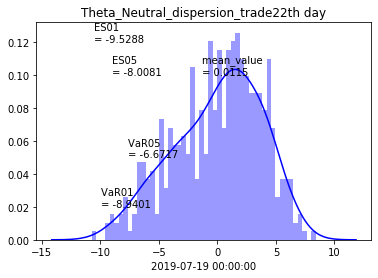

In [72]:
PandL_plot(my_simul, 22)

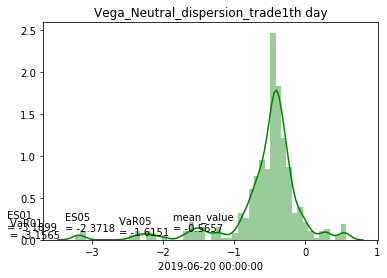

In [69]:
PandL_plot(my_simul2,1, 'Vega_Neutral_dispersion_trade', 'green')

In [58]:
def risk_measure(my_simul) :
    my_traded_data = pd.DataFrame([])
    for i in range(1,22) :
        traded_data = pd.Series(PandL(my_simul, i))
        mean_value = traded_data.mean()
        VaR05 = traded_data.quantile(0.05)
        VaR01 = traded_data.quantile(0.01)
        ES05 = traded_data[traded_data<=VaR05].mean()
        ES01 = traded_data[traded_data<=VaR01].mean()
        my_traded_data = pd.concat([my_traded_data, pd.DataFrame([mean_value,VaR05,VaR01,ES05,ES01], index = ['Mean_Profit','VaR05','VaR01','ES05','ES01'], columns = ['T='+str(i)])] , axis = 1)
    return my_traded_data

In [62]:
result1 = risk_measure(my_simul)
result2 = risk_measure(my_simul2)

In [63]:
result1[result1.columns[::5]]

,T=1,T=6,T=11,T=16,T=21
Mean_Profit,-0.540625,-0.338121,-0.316600,-0.158121,0.040542
VaR05,-1.831823,-2.876027,-3.355946,-4.784913,-6.310433
VaR01,-3.425137,-3.752397,-6.518096,-7.604888,-8.597709
ES05,-2.713370,-3.586641,-5.174367,-6.463707,-7.883382
ES01,-4.233797,-4.696018,-7.391705,-8.960894,-9.756596


In [64]:
result2[result2.columns[::5]]

,T=1,T=6,T=11,T=16,T=21
Mean_Profit,-0.565733,-0.356500,-0.368108,-0.297001,-0.129263
VaR05,-1.615066,-2.278752,-2.682341,-3.349017,-4.437280
VaR01,-3.156506,-2.928429,-3.783058,-5.077687,-6.193841
ES05,-2.371763,-2.767032,-3.362460,-4.389411,-5.391224
ES01,-3.189886,-3.438093,-4.458526,-5.883393,-6.767493


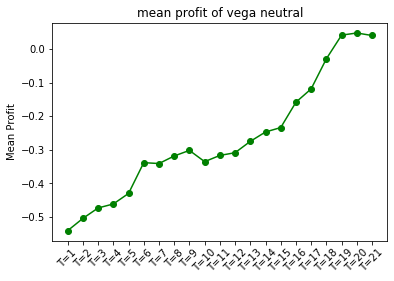

In [87]:
plt.plot(result1.iloc[0], marker = 'o', color = 'green')
plt.title('mean profit of vega neutral')
plt.xticks(rotation=45)
plt.ylabel('Mean Profit')
plt.show()

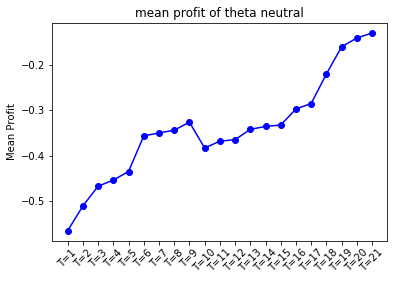

In [90]:
plt.plot(result2.iloc[0], marker = 'o', color = 'blue')
plt.title('mean profit of theta neutral')
plt.xticks(rotation=45)
plt.ylabel('Mean Profit')
plt.show()